In [1]:
# Author: Robert Guthrie

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim


torch.manual_seed(1)

In [2]:
#  current directory
import os
print(os.getcwd())

/Users/jeremiah/Studies/NLP/Ass2/BiLSTM/submission/BiLSTM/NER/BiLSTM


In [3]:
import pandas as pd
import numpy as np
import json

with open('NER_training_data.json', 'r') as file:
    training_data = json.load(file)
    # save training data into panda dataframe



with open('NER_test_data.json', 'r') as file:
    test_data = json.load(file)
    # save test data into panda dataframe

with open('NER_validation_data.json', 'r') as file:
    validation_data = json.load(file)
    # save validation data into panda dataframe



df = pd.DataFrame(training_data)
df=df.T


valdf = pd.DataFrame(validation_data)
valdf=valdf.T

testdf = pd.DataFrame(test_data)
testdf=testdf.T


texts = df['text'].tolist()
labels = df['labels'].tolist()
import re

valtexts = valdf['text'].tolist()
vallabels = valdf['labels'].tolist()

testtexts = testdf['text'].tolist()
testlabels = testdf['labels'].tolist()


def convert_data(texts, labels):
    converted_data = []
    for text, label in zip(texts, labels):
        words = text.split()
        words=[word for word in words if word!='']
        tags = label
        converted_data.append((words, tags))
    return converted_data

training_data = convert_data(texts, labels)
print(training_data[0])
validation_data = convert_data(valtexts, vallabels)

test_data = convert_data(testtexts, testlabels)


(['(7)', 'On', 'specific', 'query', 'by', 'the', 'Bench', 'about', 'an', 'entry', 'of', 'Rs.', '1,31,37,500', 'on', 'deposit', 'side', 'of', 'Hongkong', 'Bank', 'account', 'of', 'which', 'a', 'photo', 'copy', 'is', 'appearing', 'at', 'p.', '40', 'of', "assessee's", 'paper', 'book,', 'learned', 'authorised', 'representative', 'submitted', 'that', 'it', 'was', 'related', 'to', 'loan', 'from', 'broker,', 'Rahul', '&', 'Co.', 'on', 'the', 'basis', 'of', 'his', 'submission', 'a', 'necessary', 'mark', 'is', 'put', 'by', 'us', 'on', 'that', 'photo', 'copy.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])


In [4]:
tags_vals = list(set(df['labels'].sum()))
tag2idx = {t: i for i, t in enumerate(tags_vals)}
print(tag2idx)

{'B_CASE_NUMBER': 0, 'B_PROVISION': 1, 'I_WITNESS': 2, 'I_PROVISION': 3, 'B_RESPONDENT': 4, 'I_DATE': 5, 'I_GPE': 6, 'I_PETITIONER': 7, 'I_OTHER_PERSON': 8, 'B_PRECEDENT': 9, 'B_WITNESS': 10, 'I_STATUTE': 11, 'I_PRECEDENT': 12, 'B_GPE': 13, 'I_CASE_NUMBER': 14, 'B_STATUTE': 15, 'B_COURT': 16, 'I_JUDGE': 17, 'B_ORG': 18, 'I_COURT': 19, 'B_OTHER_PERSON': 20, 'I_ORG': 21, 'B_JUDGE': 22, 'O': 23, 'I_RESPONDENT': 24, 'B_DATE': 25, 'B_PETITIONER': 26}


In [5]:
import numpy as np 
import json
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from gensim.models import KeyedVectors
from collections import defaultdict

In [6]:
print(training_data[0],training_data[1])

(['(7)', 'On', 'specific', 'query', 'by', 'the', 'Bench', 'about', 'an', 'entry', 'of', 'Rs.', '1,31,37,500', 'on', 'deposit', 'side', 'of', 'Hongkong', 'Bank', 'account', 'of', 'which', 'a', 'photo', 'copy', 'is', 'appearing', 'at', 'p.', '40', 'of', "assessee's", 'paper', 'book,', 'learned', 'authorised', 'representative', 'submitted', 'that', 'it', 'was', 'related', 'to', 'loan', 'from', 'broker,', 'Rahul', '&', 'Co.', 'on', 'the', 'basis', 'of', 'his', 'submission', 'a', 'necessary', 'mark', 'is', 'put', 'by', 'us', 'on', 'that', 'photo', 'copy.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']) (['He', 'was', 'also', 'asked', 'whether', 'Agya', '<span', 'class="hidden_text"', 'id="s

In [7]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5
HIDDEN_DIM = 4
unk = "UNK"


# model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
word_to_ix = {}
for sentence, tags in training_data:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_to_ix[unk] = len(word_to_ix)

# tag_to_ix = {"B": 0, "I": 1, "O": 2, START_TAG: 3, STOP_TAG: 4}
tag_to_ix= {tag: i for i, tag in enumerate(set([tag for sentence, tags in training_data for tag in tags]))   }
tag_to_ix[START_TAG] = len(tag_to_ix)
tag_to_ix[STOP_TAG] = len(tag_to_ix)


In [8]:
import random
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    vocab_size = len(to_ix)
    idxs = []
    for w in seq:
        if w in to_ix:
            idxs.append(to_ix[w])
        else:
            # idxs.append(to_ix[unk])
            idxs.append(random.randint(0, vocab_size-1))
    return torch.tensor(idxs, dtype=torch.long)

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [9]:
print(len(test_data))

890


In [10]:
START_TAG = "<START>"   
STOP_TAG = "<STOP>"
# create a tag for unkwown data
Unk_TAG="<UNK>"

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, pretrained_embeddings=None):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        if pretrained_embeddings is not None:
            self.word_embeds = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
            print('-----Using pretrained embeddings-------')
        else:
            self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        # self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats
    

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [11]:
def load_word2vec_embeddings(filepath):
    word_vectors = KeyedVectors.load_word2vec_format(filepath, binary=True)
    return word_vectors

def prepare_embedding_matrix(word_vectors, word_to_ix, embedding_dim=300):
    matrix_len = len(word_to_ix)
    weights_matrix = torch.zeros((matrix_len, embedding_dim))

    for word, i in word_to_ix.items():
        try: 
            weights_matrix[i] = torch.from_numpy(word_vectors[word])
        except KeyError:
            weights_matrix[i] = torch.from_numpy(word_vectors["<UNK>"]) # Random initialization for words not in Word2Vec
            # weights_matrix[i] = torch.randn(embedding_dim)

    return weights_matrix


In [12]:
def calculate_f1_score(predictions, targets, tag_to_ix):
    # Convert predictions and targets to flat lists
    predictions_flat = [p for seq in predictions for p in seq]
    targets_flat = [t for seq in targets for t in seq]

    # Convert tag indices to tags
    predictions_tags = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(p)] for p in predictions_flat]
    targets_tags = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(t)] for t in targets_flat]

    # Calculate F1 score
    f1_score = metrics.f1_score(targets_tags, predictions_tags, average='weighted')
    return f1_score


In [13]:


import gensim.downloader as api
glove_vectors = api.load("glove-wiki-gigaword-300")

In [14]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
# unk = "<UNK>"

EMBEDDING_DIM = glove_vectors.vector_size
HIDDEN_DIM = 4

word_to_ix_glove = {word: idx + 1 for idx, word in enumerate(glove_vectors.index_to_key)}
word_to_ix_glove[unk] = 0

# word_vectors = load_word2vec_embeddings(word2vec_file)
# embedding_matrix = prepare_embedding_matrix(word_vectors, word_to_ix)



# model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
# word_to_ix = {}
# for sentence, tags in training_data:
#     for word in sentence:
#         if word not in word_to_ix:
#             word_to_ix[word] = len(word_to_ix)
# word_to_ix[unk] = len(word_to_ix)

# tag_to_ix = {"B": 0, "I": 1, "O": 2, START_TAG: 3, STOP_TAG: 4}
tag_to_ix= {tag: i for i, tag in enumerate(set([tag for sentence, tags in training_data for tag in tags]))   }
tag_to_ix[START_TAG] = len(tag_to_ix)
tag_to_ix[STOP_TAG] = len(tag_to_ix)

print(tag_to_ix)

# Prepare embedding matrix
# Initialize and train the model with pre-trained embeddings
model = BiLSTM_CRF(len(word_to_ix_glove), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, pretrained_embeddings=torch.FloatTensor(glove_vectors.vectors))

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)



# Check predictions before training
# with torch.no_grad():
#     precheck_sent = prepare_sequence(training_data[0][0], word_to_ix)
#     precheck_tags = torch.tensor([tag_to_ix[t] for t in training_data[0][1]], dtype=torch.long)
#     print(model(precheck_sent))


from sklearn.metrics import f1_score

# Lists to store losses and F1 scores
train_losses = []
train_f1_scores = []
val_losses = []
val_f1_scores = []
num_epochs = 3
# Training loop
for epoch in range(num_epochs):
    # show live status of each epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)
    total_train_loss = 0
    predictions = []
    true_labels = []
    train_preds = []
    # Training phase
    model.train()
    for sentence, tags in training_data:
        # Clear the gradients before training
        # print progress of each epoch after every 20% of data trainig
        if (len(sentence)!=len(tags)):
            print(sentence, tags)
            break
        if (training_data.index((sentence, tags)) % (len(training_data)//5) == 0):
            print(f"{(training_data.index((sentence, tags))/len(training_data))*100:.0f}% of data trained")

        model.zero_grad()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)
        true_labels.extend(tags)
        # Calculate the negative log likelihood loss
        loss = model.neg_log_likelihood(sentence_in, targets)
        total_train_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        with torch.no_grad():
            predictions = model(sentence_in)
            predicted_labels = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(p)] for p in predictions[1]]
            train_preds.extend(predicted_labels)
    
    train_loss = total_train_loss / len(training_data)
    train_losses.append(train_loss)
    train_f1 = f1_score(true_labels, train_preds, average='macro')
    train_f1_scores.append(train_f1)

    # Validation phase
    model.eval()
    val_loss=0
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for sentence, tags in validation_data:
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)
        
            predictions = model(sentence_in)
            val_loss += model.neg_log_likelihood(sentence_in, targets).item()

            # predictions_labels=[list(tag_to_ix.keys())[list(tag_to_ix.values()).index(p)] for p in predictions[1]]
            predictions_labels=[]
            for p in predictions[1]:
                if p in tag_to_ix.values():
                    predictions_labels.append(list(tag_to_ix.keys())[list(tag_to_ix.values()).index(p)])
                else:
                    predictions_labels.append('O')
            all_predictions.extend(predictions_labels)
            all_true_labels.extend(tags)

        
        # Calculate validation loss
        val_loss =val_loss/len(validation_data)
        val_losses.append(val_loss)
        
        # Calculate validation F1 score
        val_f1_score = f1_score(all_true_labels, all_predictions, average='macro')
        val_f1_scores.append(val_f1_score)
    
    # Print epoch statistics
    print(f"epoch {epoch+1}/{num_epochs}")
    print(f"Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f} | Validation F1 score: {val_f1_score:.4f}")
    print()









{'B_CASE_NUMBER': 0, 'B_PROVISION': 1, 'I_WITNESS': 2, 'I_PROVISION': 3, 'B_RESPONDENT': 4, 'I_DATE': 5, 'I_GPE': 6, 'I_PETITIONER': 7, 'I_OTHER_PERSON': 8, 'B_PRECEDENT': 9, 'B_WITNESS': 10, 'I_STATUTE': 11, 'I_PRECEDENT': 12, 'B_GPE': 13, 'I_CASE_NUMBER': 14, 'B_STATUTE': 15, 'B_COURT': 16, 'I_JUDGE': 17, 'B_ORG': 18, 'I_COURT': 19, 'B_OTHER_PERSON': 20, 'I_ORG': 21, 'B_JUDGE': 22, 'O': 23, 'I_RESPONDENT': 24, 'B_DATE': 25, 'B_PETITIONER': 26, '<START>': 27, '<STOP>': 28}
-----Using pretrained embeddings-------
Epoch 1/3
----------
0% of data trained
20% of data trained
40% of data trained
60% of data trained
80% of data trained
epoch 1/3
Train loss: 27.7161 | Validation loss: 9.9425 | Validation F1 score: 0.1499

Epoch 2/3
----------
0% of data trained
20% of data trained
40% of data trained


KeyboardInterrupt: 

In [15]:
# save into a .h5 model
import h5py
model_path = 'NERGloveBilstm.h5'
torch.save(model.state_dict(), model_path)

In [15]:
# optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4)
# # print("a")
# for epoch in range(2):
#     # show live status of each epoch
#     print(f"Epoch {epoch+1}/{4}")
#     print('-' * 10)
#     total_train_loss = 0
#     predictions = []
#     true_labels = []
#     train_preds = []
#     # Training phase
#     # Training phase
#     model.train()
#     for sentence, tags in training_data:
#         # Clear the gradients before training
#         # print progress of each epoch after every 20% of data trainig
#         if (len(sentence)!=len(tags)):
#             print(sentence, tags)
#             break
#         if (training_data.index((sentence, tags)) % (len(training_data)//5) == 0):
#             print(f"{(training_data.index((sentence, tags))/len(training_data))*100:.0f}% of data trained")

#         model.zero_grad()
#         sentence_in = prepare_sequence(sentence, word_to_ix)
#         targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)
        
#         # Calculate the negative log likelihood loss
#         loss = model.neg_log_likelihood(sentence_in, targets)
#         total_train_loss += loss.item()

#         true_labels.extend(tags)
#         with torch.no_grad():
#             predictions = model(sentence_in)
#             predicted_labels = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(p)] for p in predictions[1]]
#             train_preds.extend(predicted_labels)
        
#         # Backpropagation
#         loss.backward()
#         optimizer.step()
#         total_train_loss += loss.item()
    
#     train_loss = total_train_loss / len(training_data)
#     train_losses.append(train_loss)
#     train_f1 = f1_score(true_labels, train_preds, average='macro')
#     train_f1_scores.append(train_f1)
    
#     # Validation phase
#     model.eval()
#     val_loss=0
#     all_predictions = []
#     all_true_labels = []
#     with torch.no_grad():
#         for sentence, tags in validation_data:
#             sentence_in = prepare_sequence(sentence, word_to_ix)
#             targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)
        
#             predictions = model(sentence_in)
#             val_loss += model.neg_log_likelihood(sentence_in, targets).item()

#             # predictions_labels=[list(tag_to_ix.keys())[list(tag_to_ix.values()).index(p)] for p in predictions[1]]
#             predictions_labels=[]
#             for p in predictions[1]:
#                 if p in tag_to_ix.values():
#                     predictions_labels.append(list(tag_to_ix.keys())[list(tag_to_ix.values()).index(p)])
#                 else:
#                     predictions_labels.append('O')
#             all_predictions.extend(predictions_labels)
#             all_true_labels.extend(tags)

        
#         # Calculate validation loss
#         val_loss =val_loss/len(validation_data)
#         val_losses.append(val_loss)
        
#         # Calculate validation F1 score
#         val_f1_score = f1_score(all_true_labels, all_predictions, average='macro')
#         val_f1_scores.append(val_f1_score)
    
#     # Print epoch statistics
#     print(f"epoch {epoch+1}/{num_epochs}")
#     print(f"Train loss: {train_loss:.4f} | Validation loss: {val_loss:.4f} | Validation F1 score: {val_f1_score:.4f}")
#     print()


# # save model
# torch.save(model.state_dict(), 'BilstmATEGlove.pt')



Epoch 1/4
----------
0% of data trained
20% of data trained
40% of data trained
60% of data trained
80% of data trained
100% of data trained
epoch 1/3
Train loss: 9.4042 | Validation loss: 6.0524 | Validation F1 score: 0.3176

Epoch 2/4
----------
0% of data trained
20% of data trained
40% of data trained
60% of data trained
80% of data trained
100% of data trained
epoch 2/3
Train loss: 7.7823 | Validation loss: 5.1647 | Validation F1 score: 0.4090



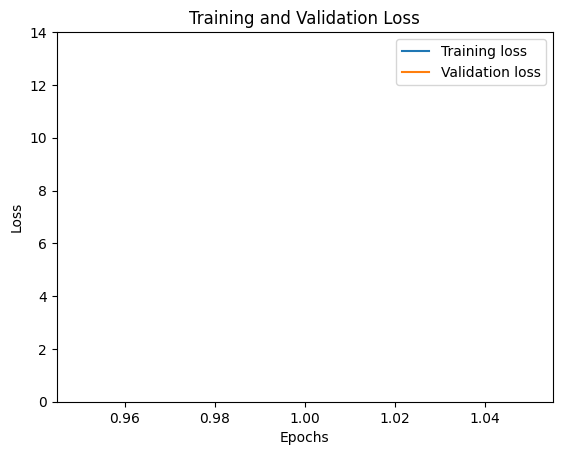

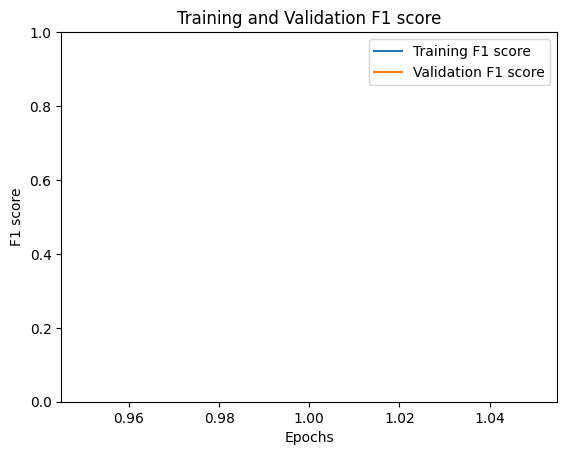

In [16]:
num_epochs = 1
#  plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs+1), train_losses, label='Training loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation loss')
#  make y bigger
plt.ylim(0, 14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the validation F1 score
plt.plot(range(1, num_epochs+1), train_f1_scores, label='Training F1 score')
plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1 score')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.title('Training and Validation F1 score')
plt.legend() 
plt.show()



In [17]:
from sklearn.metrics import f1_score
def evaluate_model(model, data, word_to_ix, tag ):
    model.eval()
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for sentence, tags in data:
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

            predictions = model(sentence_in)
            predictions_labels=[list(tag_to_ix.keys())[list(tag_to_ix.values()).index(p)] for p in predictions[1]]
            all_predictions.extend(predictions_labels)
            all_true_labels.extend(tags)
            
        print("F1 score:",f1_score(all_true_labels, all_predictions, average='macro'))
        print("Accuracy Score:",accuracy_score(all_true_labels, all_predictions))

        return None

evaluate_model(model, test_data, word_to_ix, tag_to_ix)
# print(f"Test F1 score: {test_f1_score:.4f}")

F1 score: 0.1987126393210779
Accuracy Score: 0.8777860207076734
